
 LOAN DATA ANALYSIS DASHBOARD
---------------------------------------------------
1 Count Loans by Status (for given Loan Type)
2  Total Loan Amount by Loan Type
3  Average Interest Rate by Loan Type
4  Customers with Multiple Loans
5  Loan Performance Summary (Closed vs Defaulted)
---------------------------------------------------


 Enter your choice Between (1–5):  1
Enter loan type (Home, Car, Auto, Education, Personal, Business):  home



 Executing procedure: count_loans_by_status

 Loan Status for Home Loans
------------------------------
loan_status  total_loans
     Closed          221
     Active          220
  Defaulted          127
    Pending           78
    Default           62
Charged Off           56
   Approved           54


C:\Users\dines\AppData\Local\Temp\ipykernel_13332\3646343212.py:34: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_13332\3646343212.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='loan_status', y='total_loans', palette='Set2')


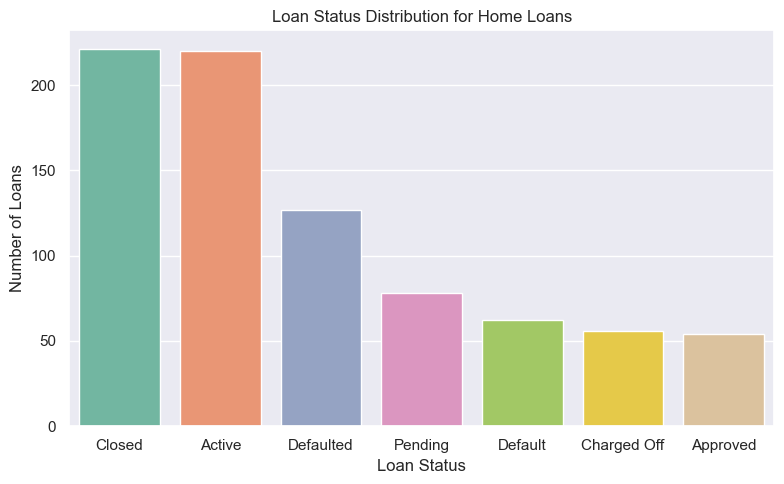

In [2]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql.connector import Error

# ---------------------------------------------------------
# Database Configuration
# ---------------------------------------------------------
db_config = {
    "host": "localhost",
    "user": "root",
    "password": "14032002kD@",
    "database": "Banking"
}

# ---------------------------------------------------------
# Generic Function to Run Stored Procedure
# ---------------------------------------------------------
def run_stored_procedure(proc_name, params=None):
    """Runs a stored procedure and returns DataFrame + updated params if OUT exists."""
    connection = None
    try:
        connection = mysql.connector.connect(**db_config)
        cursor = connection.cursor()

        print(f"\n Executing procedure: {proc_name}")
        if params is not None:
            cursor.callproc(proc_name, params)  # params must be list if OUT parameter exists
        else:
            cursor.callproc(proc_name)

        df = None
        for result in cursor.stored_results():
            rows = result.fetchall()
            columns = [col[0] for col in result.description]
            df = pd.DataFrame(rows, columns=columns)

        return df, params

    except Error as e:
        print(f" Error executing {proc_name}: {e}")
        return None, params
    finally:
        if 'cursor' in locals(): cursor.close()
        if connection and connection.is_connected(): connection.close()


# ---------------------------------------------------------
# Table Display Helper
# ---------------------------------------------------------
def show_table(df, title=None):
    if title:
        print(f"\n {title}\n" + "-" * (len(title) + 4))
    
    if df is None or df.empty:
        print(" No rows to display.")
        return
    
    total_rows = len(df)
    if total_rows <= 10:
        print(df.to_string(index=False))
    else:
        print("\nShowing first 5 and last 5 rows:\n")
        print(df.head(5).to_string(index=False))
        print("\n...\n")
        print(df.tail(5).to_string(index=False))
        print(f"\n Total Rows: {total_rows}")


# ---------------------------------------------------------
# Visualization Functions
# ---------------------------------------------------------
def visualize_loans_by_status(df, loan_type):
    show_table(df, f"Loan Status for {loan_type} Loans")
    plt.figure(figsize=(8,5))
    sns.barplot(data=df, x='loan_status', y='total_loans', palette='Set2')
    plt.title(f'Loan Status Distribution for {loan_type} Loans')
    plt.xlabel("Loan Status"); plt.ylabel("Number of Loans")
    plt.tight_layout(); plt.show()

def visualize_total_loan_amount(df):
    show_table(df, "Total Loan Amount by Loan Type")
    plt.figure(figsize=(8,5))
    sns.barplot(data=df, x='loan_type', y='total_disbursed_amount', palette='coolwarm')
    plt.title('Total Loan Amount Disbursed by Loan Type')
    plt.xlabel("Loan Type"); plt.ylabel("Total Amount (₹)")
    plt.tight_layout(); plt.show()

def visualize_avg_interest_rate(df):
    show_table(df, "Average Interest Rate by Loan Type")
    plt.figure(figsize=(8,5))
    sns.barplot(data=df, x='loan_type', y='avg_interest_rate', palette='viridis')
    plt.title('Average Interest Rate by Loan Type')
    plt.xlabel("Loan Type"); plt.ylabel("Avg Interest Rate (%)")
    plt.tight_layout(); plt.show()

def visualize_multiple_loans(df):
    show_table(df, "Customers with Multiple Loans")
    plt.figure(figsize=(8,5))
    sns.barplot(data=df.head(10), x='full_name', y='total_loans', palette='magma')
    plt.title('Top Customers with Multiple Loans')
    plt.xlabel("Customer Name"); plt.ylabel("Number of Loans")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.show()

def visualize_loan_performance(df):
    show_table(df, "Loan Performance Summary (Closed vs Defaulted)")
    plt.figure(figsize=(6,5))
    plt.pie(df['percentage'], labels=df['status'], autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    plt.title('Loan Performance: Repaid vs Defaulted')
    plt.tight_layout(); plt.show()


# ---------------------------------------------------------
# Main Menu for User Interaction
# ---------------------------------------------------------
def main():
    print("\n LOAN DATA ANALYSIS DASHBOARD")
    print("---------------------------------------------------")
    print("1 Count Loans by Status (for given Loan Type)")
    print("2  Total Loan Amount by Loan Type")
    print("3  Average Interest Rate by Loan Type")
    print("4  Customers with Multiple Loans")
    print("5  Loan Performance Summary (Closed vs Defaulted)")
    print("---------------------------------------------------")

    choice = input(" Enter your choice Between (1–5): ").strip()

    if choice == '1':
        loan_type = input("Enter loan type (Home, Car, Auto, Education, Personal, Business): ").title().strip()
        params = [loan_type, 0]  # OUT parameter included
        df, updated = run_stored_procedure('count_loans_by_status', params)
        if df is not None and not df.empty:
            visualize_loans_by_status(df, loan_type)
        else:
            print(" No data available for this loan type.")

    elif choice == '2':
        df, _ = run_stored_procedure('total_loan_amount_by_type')
        visualize_total_loan_amount(df)

    elif choice == '3':
        df, _ = run_stored_procedure('avg_interest_rate_by_type')
        visualize_avg_interest_rate(df)

    elif choice == '4':
        df, _ = run_stored_procedure('customers_with_multiple_loans')
        visualize_multiple_loans(df)

    elif choice == '5':
        df, _ = run_stored_procedure('loan_performance_summary')
        visualize_loan_performance(df)

    else:
        print(" Invalid choice. Please select 1–5.")


# ---------------------------------------------------------
# Run Program
# ---------------------------------------------------------
if __name__ == "__main__":
    sns.set_theme()
    main()
